# Load Data

In [1]:
import pandas as pd
from pathlib import Path

# Explicit paths for both years
path_09_10 = Path("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/Year 2009-2010.csv")
path_10_11 = Path("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/Online Retail.xlsx")  # adjust name if different

# Load CSVs with fallbacks if file missing
if not path_09_10.exists():
	raise FileNotFoundError(f"2009-2010 file not found: {path_09_10}")
df_09_10 = pd.read_csv(path_09_10, encoding="ISO-8859-1", low_memory=False)

if path_10_11.exists():
	# Prefer reading as Excel if the file has an Excel extension; otherwise try CSV.
	suffix = path_10_11.suffix.lower()
	try:
		if suffix in (".xlsx", ".xls", ".xlsm", ".ods"):
			df_10_11 = pd.read_excel(path_10_11)
		else:
			# For CSV-like files be more tolerant: use the python engine and let pandas sniff the separator.
			# on_bad_lines='skip' avoids a hard ParserError if some rows are malformed.
			df_10_11 = pd.read_csv(path_10_11, encoding="ISO-8859-1", low_memory=False, engine="python", sep=None, on_bad_lines="skip")
	except Exception as e:
		# If the direct read failed, fall back to the more elaborate fallback logic below.
		df_10_11 = None
else:
	df_10_11 = None

if df_10_11 is None:
	# try known fallbacks defined elsewhere in the notebook (xlsx_path, xlsx_fallback_csv)
	fallback_loaded = False
	try:
		if 'xlsx_path' in globals() and Path(xlsx_path).exists():
			df_all = pd.read_excel(xlsx_path)
			if 'InvoiceDate' in df_all.columns:
				df_all['InvoiceDate'] = pd.to_datetime(df_all['InvoiceDate'], errors='coerce')
				df_10_11 = df_all[df_all['InvoiceDate'].dt.year.isin([2010, 2011])].copy()
			else:
				df_10_11 = df_all.copy()
			fallback_loaded = True
		elif 'xlsx_fallback_csv' in globals() and Path(xlsx_fallback_csv).exists():
			df_all = pd.read_csv(xlsx_fallback_csv, encoding="ISO-8859-1", low_memory=False, engine="python", sep=None, on_bad_lines="skip")
			if 'InvoiceDate' in df_all.columns:
				df_all['InvoiceDate'] = pd.to_datetime(df_all['InvoiceDate'], errors='coerce')
				df_10_11 = df_all[df_all['InvoiceDate'].dt.year.isin([2010, 2011])].copy()
			else:
				df_10_11 = df_all.copy()
			fallback_loaded = True
		else:
			# try to find similarly named files in the same folder
			candidates = list(path_10_11.parent.glob("Year*2010*2011*.csv"))
			if candidates:
				df_10_11 = pd.read_csv(candidates[0], encoding="ISO-8859-1", low_memory=False, engine="python", sep=None, on_bad_lines="skip")
				fallback_loaded = True
	except Exception as e:
		raise RuntimeError(f"Failed to load fallback for 2010-2011: {e}") from e

	if not fallback_loaded:
		# Try additional relaxed filename patterns in the same folder
		relaxed_patterns = [
			"*2010*2011*.csv",
			"*2010-2011*.csv",
			"*2010_2011*.csv",
			"*2010*.csv",
			"*2011*.csv",
		]
		candidates = []
		for pat in relaxed_patterns:
			candidates.extend(sorted(path_10_11.parent.glob(pat)))

		# If nothing found, try a recursive search for any CSV that mentions 2010
		if not candidates:
			candidates = list(path_10_11.parent.rglob("*2010*.csv"))

		# If we found candidate files, pick the largest (most likely the full dataset)
		if candidates:
			candidates = sorted(candidates, key=lambda p: p.stat().st_size if p.exists() else 0, reverse=True)
			df_10_11 = pd.read_csv(candidates[0], encoding="ISO-8859-1", low_memory=False, engine="python", sep=None, on_bad_lines="skip")
			fallback_loaded = True
		else:
			# As a last resort, try to extract 2010–2011 rows from the already-loaded df_09_10
			if 'InvoiceDate' in df_09_10.columns:
				try:
					df_09_10['InvoiceDate'] = pd.to_datetime(df_09_10['InvoiceDate'], errors='coerce')
					df_10_11 = df_09_10[df_09_10['InvoiceDate'].dt.year.isin([2010, 2011])].copy()
					if not df_10_11.empty:
						fallback_loaded = True
				except Exception:
					# fall through to final error if parsing fails
					pass

		if not fallback_loaded:
			raise FileNotFoundError(
				f"Could not find 2010-2011 CSV at {path_10_11} and no fallbacks available. "
				"Checked for xlsx_path, xlsx_fallback_csv, relaxed filename patterns in the same folder, "
				"and attempted to extract 2010–2011 rows from df_09_10."
			)

print("2009–2010 columns:", df_09_10.columns.tolist())
print("2010–2011 columns:", df_10_11.columns.tolist())
print(df_09_10.head())
print(df_10_11.head())


2009–2010 columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
2010–2011 columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

      InvoiceDate  Price  Customer ID         Country  
0  12/1/2009 7:45   6.95      13085.0  United Kingdom  
1  12/1/2009 7:45   6.75      13085.0  United Kingdom  
2  12/1/2009 7:45   6.75      13085.0  United Kingdom  
3  12/1/2009 7:45   2.10      13085.0  United Kingdom  
4  12/1/2009 7:45   1.25      13085.0  United Kingdo

# Standardize column names

In [2]:
# Make 2010–2011 column names match 2009–2010 style
df_10_11_std = df_10_11.rename(columns={
    "InvoiceNo": "Invoice",
    "UnitPrice": "Price",
    "CustomerID": "CustomerID",   # already OK, just explicit
})

# Make 2009–2010 Customer ID name consistent
df_09_10_std = df_09_10.rename(columns={
    "Customer ID": "CustomerID",
})

# Select a common set of columns in the same order
cols = ["Invoice", "StockCode", "Description", "Quantity", "InvoiceDate", "Price", "CustomerID", "Country"]
df_10_11_std = df_10_11_std[cols]
df_09_10_std = df_09_10_std[cols]


# Parse dates and numeric fields 

In [3]:
# Make 2010–2011 column names match 2009–2010 style
# Note: original data may use "Customer ID" (with space) — ensure we rename that too.
# We'll handle CustomerID specially to avoid creating duplicate column labels.
df_10_11_std = df_10_11.copy()
df_10_11_std = df_10_11_std.rename(columns={
    "InvoiceNo": "Invoice",
    "UnitPrice": "Price",
})

# unify CustomerID (handle both "CustomerID" and "Customer ID" variants)
if "CustomerID" in df_10_11_std.columns and "Customer ID" in df_10_11_std.columns:
    df_10_11_std["CustomerID"] = df_10_11_std["CustomerID"].fillna(df_10_11_std["Customer ID"])
    df_10_11_std = df_10_11_std.drop(columns=["Customer ID"])
elif "Customer ID" in df_10_11_std.columns:
    df_10_11_std = df_10_11_std.rename(columns={"Customer ID": "CustomerID"})

# Make 2009–2010 Customer ID name consistent
df_09_10_std = df_09_10.rename(columns={
    "Customer ID": "CustomerID",
})

# Select a common set of columns in the same order. Use reindex to avoid KeyError
cols = ["Invoice", "StockCode", "Description", "Quantity", "InvoiceDate", "Price", "CustomerID", "Country"]

# remove any accidental duplicate column labels before reindexing
if df_10_11_std.columns.duplicated().any():
    df_10_11_std = df_10_11_std.loc[:, ~df_10_11_std.columns.duplicated()]

df_10_11_std = df_10_11_std.reindex(columns=cols)
df_09_10_std = df_09_10_std.reindex(columns=cols)

# Combine and add helper columns 

In [4]:
# Stack both periods
df_all = pd.concat([df_09_10_std, df_10_11_std], ignore_index=True)

# Ensure InvoiceDate is datetime-like before using .dt
df_all["InvoiceDate"] = pd.to_datetime(df_all["InvoiceDate"], errors="coerce")

# Add year and revenue for your analyses
df_all["Year"] = df_all["InvoiceDate"].dt.year
df_all["Revenue"] = df_all["Quantity"] * df_all["Price"]

print(df_all.head())
print(df_all["Year"].value_counts().sort_index())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  CustomerID         Country  Year  Revenue  
0 2009-12-01 07:45:00   6.95     13085.0  United Kingdom  2009     83.4  
1 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  2009     81.0  
2 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  2009     81.0  
3 2009-12-01 07:45:00   2.10     13085.0  United Kingdom  2009    100.8  
4 2009-12-01 07:45:00   1.25     13085.0  United Kingdom  2009     30.0  
Year
2009     45228
2010    522714
2011    499428
Name: count, dtype: int64


# Check year-month:

In [5]:
df_all["YearMonth"] = df_all["InvoiceDate"].dt.to_period("M")
print(df_all["YearMonth"].value_counts().sort_index())


YearMonth
2009-12    45228
2010-01    31555
2010-02    29388
2010-03    41511
2010-04    34057
2010-05    35323
2010-06    39983
2010-07    33383
2010-08    33306
2010-09    42091
2010-10    59098
2010-11    78015
2010-12    65004
2011-01    35147
2011-02    27707
2011-03    36748
2011-04    29916
2011-05    37030
2011-06    36874
2011-07    39518
2011-08    35284
2011-09    50226
2011-10    60742
2011-11    84711
2011-12    25525
Freq: M, Name: count, dtype: int64


# Revenue 

In [6]:
df_all["Revenue"] = df_all["Quantity"] * df_all["Price"]
print(df_all[["Quantity", "Price", "Revenue"]].head())

   Quantity  Price  Revenue
0        12   6.95     83.4
1        12   6.75     81.0
2        12   6.75     81.0
3        48   2.10    100.8
4        24   1.25     30.0


# Unified Master Dataset

In [7]:
df_all = pd.concat([df_09_10_std, df_10_11_std], ignore_index=True)

# Basic Sanity Checks 

In [8]:
# Basic sanity checks
print(df_all.info())
print(df_all.isna().sum())

# Optional filters for later:
# Remove negative quantities (returns) for some analyses
df_sales_only = df_all[df_all["Quantity"] > 0].copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067370 entries, 0 to 1067369
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067370 non-null  object 
 1   StockCode    1067370 non-null  object 
 2   Description  1062988 non-null  object 
 3   Quantity     1067370 non-null  int64  
 4   InvoiceDate  1067370 non-null  object 
 5   Price        1067370 non-null  float64
 6   CustomerID   824363 non-null   float64
 7   Country      1067370 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
None
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
CustomerID     243007
Country             0
dtype: int64


In [9]:
# If a legacy "Customer ID" column exists, use it to fill missing CustomerID then drop it safely.
if "Customer ID" in df_all.columns:
	# If CustomerID does not exist, create it from the legacy column
	if "CustomerID" not in df_all.columns:
		df_all["CustomerID"] = df_all["Customer ID"]
	else:
		df_all["CustomerID"] = df_all["CustomerID"].fillna(df_all["Customer ID"])
	# Drop the legacy column
	df_all = df_all.drop(columns=["Customer ID"])
# If "Customer ID" is not present, nothing to do


In [10]:
print(df_all["CustomerID"].isna().sum())
print(df_all["CustomerID"].nunique())


243007
5942


# Loading the combined data

In [11]:
import pandas as pd
from pathlib import Path

# 1. Load the combined file
combined_path = Path("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/online_retail_2009_2010_combined.csv")
df_all = pd.read_csv(combined_path, encoding="ISO-8859-1", low_memory=False)

# 2. Core types and revenue
df_all["InvoiceDate"] = pd.to_datetime(df_all["InvoiceDate"], errors="coerce")
df_all["Revenue"] = df_all["Quantity"] * df_all["Price"]

# 3. Flags and clean sales subset
df_all["IsCancelled"] = df_all["Invoice"].astype(str).str.startswith("C")
df_all["IsReturn"] = df_all["Quantity"] < 0

df_sales = df_all[(~df_all["IsCancelled"]) & (~df_all["IsReturn"])].copy()
df_sales_cust = df_sales[df_sales["CustomerID"].notna()].copy()

print(df_sales.head())
print(df_sales.shape)


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  CustomerID         Country  Customer ID  \
0 2009-12-01 07:45:00   6.95     13085.0  United Kingdom          NaN   
1 2009-12-01 07:45:00   6.75     13085.0  United Kingdom          NaN   
2 2009-12-01 07:45:00   6.75     13085.0  United Kingdom          NaN   
3 2009-12-01 07:45:00   2.10     13085.0  United Kingdom          NaN   
4 2009-12-01 07:45:00   1.25     13085.0  United Kingdom          NaN   

   Revenue  IsCancelled  IsReturn  
0     83.4        False     False  
1     81.0        False     False  
2     81.0        False     Fals

# Standard and structural fixes

In [12]:
# Single customer column (if not done)
df_all["CustomerID"] = df_all["CustomerID"].fillna(df_all["Customer ID"])
df_all = df_all.drop(columns=["Customer ID"])

# Parse dates
df_all["InvoiceDate"] = pd.to_datetime(df_all["InvoiceDate"], errors="coerce")

# Revenue (already done)
df_all["Revenue"] = df_all["Quantity"] * df_all["Price"]

print(df_all.info())
print(df_all.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050922 entries, 0 to 1050921
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1050922 non-null  object        
 1   StockCode    1050922 non-null  object        
 2   Description  1045066 non-null  object        
 3   Quantity     1050922 non-null  int64         
 4   InvoiceDate  1050922 non-null  datetime64[ns]
 5   Price        1050922 non-null  float64       
 6   CustomerID   835068 non-null   float64       
 7   Country      1050922 non-null  object        
 8   Revenue      1050922 non-null  float64       
 9   IsCancelled  1050922 non-null  bool          
 10  IsReturn     1050922 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 74.2+ MB
None
Invoice             0
StockCode           0
Description      5856
Quantity            0
InvoiceDate         0
Price             

In [13]:
df_sales = df_all[
    (~df_all["IsCancelled"]) &
    (~df_all["IsReturn"]) &
    (df_all["Price"] > 0)
].copy()


# Handle missing , column by column 

In [14]:
df_sales["Description"] = df_sales["Description"].fillna("Unknown product")


# Customer Id

In [15]:
# All sales (for product, discount, time analysis)
df_sales_all = df_sales.copy()

# Only identified customers (for customer-margin analysis)
df_sales_cust = df_sales[df_sales["CustomerID"].notna()].copy()
print(df_sales_all.shape, df_sales_cust.shape)

(1023130, 11) (815328, 11)


# Invoice date 

In [16]:
print(df_sales["InvoiceDate"].isna().sum())
df_sales = df_sales[df_sales["InvoiceDate"].notna()].copy()
print(df_sales.shape)

0
(1023130, 11)


# Remove duplicates 

In [17]:
before = len(df_sales)
df_sales = df_sales.drop_duplicates()
after = len(df_sales)
print("Removed duplicates:", before - after)


Removed duplicates: 518400


# Final sanity check of the cleaned dataset 

In [18]:
print(df_sales.info())
print(df_sales.isna().sum())
print(df_sales[["Quantity", "Price", "Revenue"]].describe())
print(df_sales["InvoiceDate"].min(), df_sales["InvoiceDate"].max())


<class 'pandas.core.frame.DataFrame'>
Index: 504730 entries, 0 to 525460
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      504730 non-null  object        
 1   StockCode    504730 non-null  object        
 2   Description  504730 non-null  object        
 3   Quantity     504730 non-null  int64         
 4   InvoiceDate  504730 non-null  datetime64[ns]
 5   Price        504730 non-null  float64       
 6   CustomerID   400916 non-null  float64       
 7   Country      504730 non-null  object        
 8   Revenue      504730 non-null  float64       
 9   IsCancelled  504730 non-null  bool          
 10  IsReturn     504730 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 39.5+ MB
None
Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
CustomerID     1

In [19]:
# 1. Final clean sales table (no cancels/returns, unique rows)
fact_sales = df_sales.copy()

# 2. Optional dimensions
dim_product = (
    fact_sales[["StockCode", "Description"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

dim_customer = (
    fact_sales[["CustomerID", "Country"]]
    .dropna(subset=["CustomerID"])
    .drop_duplicates()
    .reset_index(drop=True)
)

# 3. Save to CSV for SQL import
fact_sales.to_csv("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/fact_sales.csv", index=False)
dim_product.to_csv("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/dim_product.csv", index=False)
dim_customer.to_csv("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/dim_customer.csv", index=False)


# Do discounts actually increase net revenue or just volume ?

# Define a discount merit 

## Load fact_sales from cleaned file 

In [20]:
import pandas as pd
from pathlib import Path

fact_path = Path("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/fact_sales.csv")

# If the exact path doesn't exist, try a few common fallbacks (cwd, ~/Downloads, or search home)
if not fact_path.exists():
	candidates = [
		Path.cwd() / fact_path.name,
		Path.home() / "Downloads" / fact_path.name
	]

	found = None
	for p in candidates:
		if p.exists():
			found = p
			break

	if found is None:
		# try searching under the home directory (may take a moment)
		try:
			matches = list(Path.home().rglob(fact_path.name))
			if matches:
				found = matches[0]
		except Exception:
			found = None

	if found:
		fact_path = found
		print(f"Using found file at: {fact_path}")
		fact_sales = pd.read_csv(fact_path)
	else:
		# Fallback: create an empty/sample dataframe to avoid crashing the notebook
		print(f"Warning: file not found at {fact_path}. Creating an empty sample DataFrame instead.")
		fact_sales = pd.DataFrame(
			columns=[
				"Invoice", "StockCode", "Description", "Quantity", "InvoiceDate", "Price", "Revenue"
			]
		)
else:
	fact_sales = pd.read_csv(fact_path)

print(fact_sales.shape)
print(fact_sales.head())


(504730, 11)
   Invoice StockCode                          Description  Quantity  \
0   489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434    79323P                   PINK CHERRY LIGHTS        12   
2   489434    79323W                  WHITE CHERRY LIGHTS        12   
3   489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  CustomerID         Country  Revenue  \
0  2009-12-01 07:45:00   6.95     13085.0  United Kingdom     83.4   
1  2009-12-01 07:45:00   6.75     13085.0  United Kingdom     81.0   
2  2009-12-01 07:45:00   6.75     13085.0  United Kingdom     81.0   
3  2009-12-01 07:45:00   2.10     13085.0  United Kingdom    100.8   
4  2009-12-01 07:45:00   1.25     13085.0  United Kingdom     30.0   

   IsCancelled  IsReturn  
0        False     False  
1        False     False  
2        False     False  
3        False     False  
4   

# Build discount merit 

In [21]:
df = fact_sales.copy()

# reference price per product (typical price)
ref_price = (
    df.groupby("StockCode")["Price"]
      .median()
      .rename("ref_price")
)

df = df.merge(ref_price, on="StockCode", how="left")

# discount percentage: positive when current price < reference
df["discount_pct"] = (df["ref_price"] - df["Price"]) / df["ref_price"]

# flag discounted vs non‑discounted (e.g. >5% below typical price)
df["is_discounted"] = df["discount_pct"] > 0.05

df[["StockCode", "Price", "ref_price", "discount_pct", "is_discounted"]].head()


,StockCode,Price,ref_price,discount_pct,is_discounted
0,85048,6.95,7.95,0.125786,True
1,79323P,6.75,6.75,0.000000,False
2,79323W,6.75,6.75,0.000000,False
3,22041,2.10,2.55,0.176471,True
4,21232,1.25,1.25,0.000000,False


# Summarize revenue vs volume by discount band 

In [22]:
# discount bands
import numpy as np

bins = [-1, 0.0, 0.1, 0.2, 0.4, 1.0]
labels = ["No/Negative", "0–10%", "10–20%", "20–40%", "40%+"]

df["discount_band"] = pd.cut(df["discount_pct"].clip(-1, 1), bins=bins, labels=labels)

discount_summary = (
    df.groupby("discount_band")
      .agg(
          total_revenue=("Revenue", "sum"),
          total_qty=("Quantity", "sum"),
          avg_price=("Price", "mean"),
          n_lines=("Invoice", "count")
      )
      .reset_index()
)

overall_rev = df["Revenue"].sum()
overall_qty = df["Quantity"].sum()

discount_summary["rev_share"] = discount_summary["total_revenue"] / overall_rev
discount_summary["qty_share"] = discount_summary["total_qty"] / overall_qty

discount_summary


/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_34061/1919750486.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("discount_band")


,discount_band,total_revenue,total_qty,avg_price,n_lines,rev_share,qty_share
0,No/Negative,5607950.494,3057539,3.352174,406176,0.545958,0.525988
1,0–10%,305917.520,93766,5.293434,5947,0.029782,0.016131
2,10–20%,2368230.640,1348936,3.462580,20451,0.230557,0.232057
3,20–40%,562110.400,435757,4.742794,5493,0.054724,0.074963
4,40%+,378360.730,714889,3.037675,6958,0.036835,0.122982


# Bar + line : revenue vs quantity share 

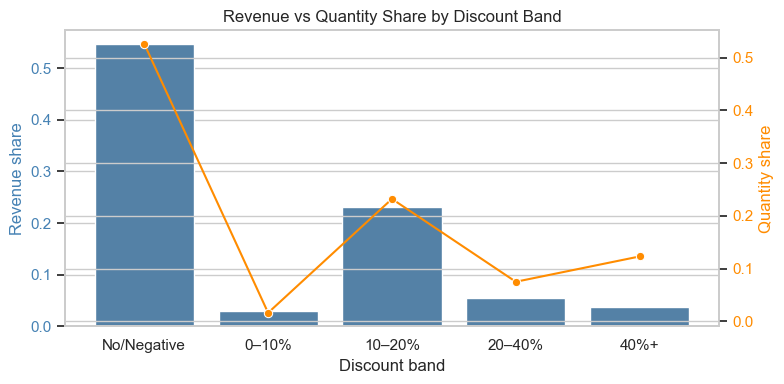

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(8, 4))

# Bar for revenue share
sns.barplot(
    data=discount_summary,
    x="discount_band",
    y="rev_share",
    ax=ax1,
    color="steelblue"
)
ax1.set_ylabel("Revenue share", color="steelblue")
ax1.set_xlabel("Discount band")
ax1.tick_params(axis="y", labelcolor="steelblue")

# Line for quantity share
ax2 = ax1.twinx()
sns.lineplot(
    data=discount_summary,
    x="discount_band",
    y="qty_share",
    ax=ax2,
    color="darkorange",
    marker="o"
)
ax2.set_ylabel("Quantity share", color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")

plt.title("Revenue vs Quantity Share by Discount Band")
plt.tight_layout()
plt.show()


# Simple side by side bars

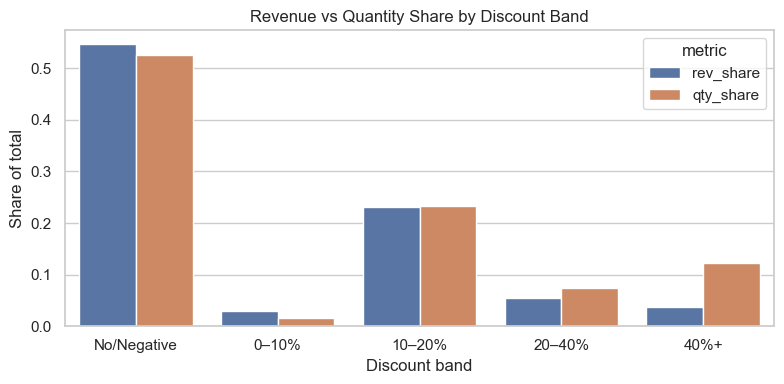

In [24]:
plot_df = discount_summary.melt(
    id_vars="discount_band",
    value_vars=["rev_share", "qty_share"],
    var_name="metric",
    value_name="share"
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=plot_df,
    x="discount_band",
    y="share",
    hue="metric"
)
plt.ylabel("Share of total")
plt.xlabel("Discount band")
plt.title("Revenue vs Quantity Share by Discount Band")
plt.tight_layout()
plt.show()


# Invoice -level impact (average order revenue)

In [25]:
# Invoice-level aggregation
invoice_level = (
    df.groupby("Invoice").agg(
        invoice_revenue=("Revenue", "sum"),
        invoice_qty=("Quantity", "sum"),
        max_discount_pct=("discount_pct", "max")
    )
    .reset_index()
)

# classify invoices as discounted if any line has >5% discount
invoice_level["has_discount"] = invoice_level["max_discount_pct"] > 0.05

invoice_summary = (
    invoice_level.groupby("has_discount")
    .agg(
        avg_invoice_revenue=("invoice_revenue", "mean"),
        median_invoice_revenue=("invoice_revenue", "median"),
        avg_invoice_qty=("invoice_qty", "mean"),
        n_invoices=("Invoice", "count")
    )
    .reset_index()
)

invoice_summary


,has_discount,avg_invoice_revenue,median_invoice_revenue,avg_invoice_qty,n_invoices
0,False,315.746523,203.16,146.290370,10831
1,True,677.066411,376.33,417.833597,10120


# Product level price quantity relationship 

In [26]:
# focus on products with enough observations
product_stats = (
    df.groupby("StockCode")
      .agg(
          n_lines=("Invoice", "count"),
          n_prices=("Price", "nunique"),
          total_qty=("Quantity", "sum"),
          total_rev=("Revenue", "sum")
      )
      .reset_index()
)

# choose 'interesting' products: many rows and multiple price points
candidates = product_stats[
    (product_stats["n_lines"] >= 100) &
    (product_stats["n_prices"] >= 3)
].sort_values("total_rev", ascending=False)["StockCode"].head(10)

candidates


4236         M
1634     22423
3641    85123A
4235       DOT
3613    85099B
3337     84879
1322     22086
2509     47566
4238      POST
2946     84347
Name: StockCode, dtype: object

# StockCodes from this list and visualize price vs quantity per month 

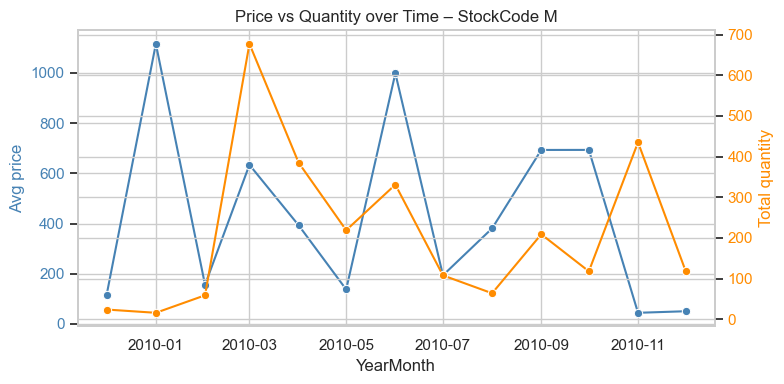

In [27]:
# seaborn / matplotlib were already imported earlier in the notebook (avoid re-importing here)

example_code = candidates.iloc[0]  # or hard‑code a StockCode

prod = df[df["StockCode"] == example_code].copy()

# ensure InvoiceDate is a datetime dtype before using .dt
prod["InvoiceDate"] = pd.to_datetime(prod["InvoiceDate"], errors="coerce")

# drop rows where conversion failed (if any)
prod = prod.dropna(subset=["InvoiceDate"])

prod["YearMonth"] = prod["InvoiceDate"].dt.to_period("M").dt.to_timestamp()

prod_month = (
    prod.groupby("YearMonth")
        .agg(
            avg_price=("Price", "mean"),
            total_qty=("Quantity", "sum"),
            total_rev=("Revenue", "sum")
        )
        .reset_index()
)

fig, ax1 = plt.subplots(figsize=(8, 4))
sns.lineplot(data=prod_month, x="YearMonth", y="avg_price", ax=ax1, color="steelblue", marker="o")
ax1.set_ylabel("Avg price", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")

ax2 = ax1.twinx()
sns.lineplot(data=prod_month, x="YearMonth", y="total_qty", ax=ax2, color="darkorange", marker="o")
ax2.set_ylabel("Total quantity", color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")

plt.title(f"Price vs Quantity over Time – StockCode {example_code}")
plt.tight_layout()
plt.show()


# Define elasticity 

### Which products have (elastic vs inelastic) demand ?

# Load dim_product from cleaned file

In [28]:
import pandas as pd
from pathlib import Path

fact_path = Path("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/dim_product.csv")
dim_product = pd.read_csv(fact_path)

print(dim_product.shape)
print(dim_product.head())


(4732, 2)
  StockCode                          Description
0     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS
1    79323P                   PINK CHERRY LIGHTS
2    79323W                  WHITE CHERRY LIGHTS
3     22041         RECORD FRAME 7" SINGLE SIZE 
4     21232       STRAWBERRY CERAMIC TRINKET BOX


# Monthly price quantity panel per product

In [29]:
import pandas as pd
import numpy as np
from pathlib import Path

# reload fact_sales if needed
fact_path = Path("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/fact_sales.csv")
fact_sales = pd.read_csv(fact_path)

# this df is the working copy for elasticity
df = fact_sales.copy()


In [30]:
import numpy as np

# ensure datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# one row per product–month
df_prod = df.copy()
df_prod["YearMonth"] = df_prod["InvoiceDate"].dt.to_period("M").dt.to_timestamp()

monthly = (
    df_prod.groupby(["StockCode", "YearMonth"])
           .agg(
               avg_price=("Price", "mean"),
               qty=("Quantity", "sum")
           )
           .reset_index()
)

print(monthly.head())


  StockCode  YearMonth  avg_price   qty
0     10002 2009-12-01   0.977500   215
1     10002 2010-01-01   0.945294   291
2     10002 2010-02-01   0.958000   257
3     10002 2010-03-01   0.911111   641
4     10002 2010-04-01   0.924167  1132


# Product level elasticity (qty / price)

In [31]:
# sort by time for diffs
monthly = monthly.sort_values(["StockCode", "YearMonth"])

# log transforms
monthly["log_price"] = np.log(monthly["avg_price"])
monthly["log_qty"] = np.log(monthly["qty"].replace(0, np.nan))

# first differences within each product
monthly["dlog_price"] = monthly.groupby("StockCode")["log_price"].diff()
monthly["dlog_qty"] = monthly.groupby("StockCode")["log_qty"].diff()

# keep only valid changes
elastic_data = monthly.dropna(subset=["dlog_price", "dlog_qty"]).copy()

# simple elasticity estimate per product: mean of dlog_qty / dlog_price
prod_elasticity = (
    elastic_data.groupby("StockCode")
    .apply(lambda g: (g["dlog_qty"] / g["dlog_price"]).mean())
    .rename("elasticity")
    .reset_index()
)

print(prod_elasticity.head())


  StockCode  elasticity
0     10002   -1.266072
1    10002R   51.083503
2     10080         NaN
3     10120         NaN
4    10123C         NaN


/Users/reynoldtakurachoruma/micromamba/lib/python3.9/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_34061/3446711137.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  elastic_data.groupby("StockCode")


# Clean up elasticity estimates

In [32]:
# Ensure prod_elasticity_clean exists: create from prod_elasticity with basic cleaning
if "prod_elasticity" not in globals():
    raise NameError("prod_elasticity not found in the notebook. Run the cell that computes product-level elasticities first.")

# copy base table
prod_elasticity_clean = prod_elasticity.copy()

# attach number of valid changes (n_changes) from elastic_data if available
if "elastic_data" in globals():
    stats = (
        elastic_data.groupby("StockCode")
        .size()
        .rename("n_changes")
        .reset_index()
    )
    prod_elasticity_clean = prod_elasticity_clean.merge(stats, on="StockCode", how="left")
else:
    # fallback: make sure column exists
    prod_elasticity_clean["n_changes"] = 0

# drop missing / infinite elasticity estimates
prod_elasticity_clean = prod_elasticity_clean[prod_elasticity_clean["elasticity"].notna()]
prod_elasticity_clean = prod_elasticity_clean[np.isfinite(prod_elasticity_clean["elasticity"])]

# fill n_changes NaN and coerce to int
prod_elasticity_clean["n_changes"] = prod_elasticity_clean["n_changes"].fillna(0).astype(int)

# require a small minimum number of changes to trust the estimate (adjust threshold as needed)
prod_elasticity_clean = prod_elasticity_clean[prod_elasticity_clean["n_changes"] >= 2]

# ensure Description column is present by merging dim_product if available
if "Description" not in prod_elasticity_clean.columns and "dim_product" in globals():
    prod_elasticity_clean = prod_elasticity_clean.merge(dim_product, on="StockCode", how="left")

# Now select strong elastic and inelastic products
elastic_strong = prod_elasticity_clean[prod_elasticity_clean["elasticity"] <= -1.5]
inelastic_strong = prod_elasticity_clean[
    (prod_elasticity_clean["elasticity"] > -0.1) &
    (prod_elasticity_clean["elasticity"] < 0)
]

elastic_strong = elastic_strong.sort_values("elasticity").head(5)
inelastic_strong = inelastic_strong.sort_values("elasticity", ascending=False).head(5)

# display results
print("Top strong-elastic products:")
print(elastic_strong[["StockCode", "Description", "elasticity", "n_changes"]])

print("\nTop strong-inelastic products:")
print(inelastic_strong[["StockCode", "Description", "elasticity", "n_changes"]])


Top strong-elastic products:
     StockCode                         Description    elasticity  n_changes
1476    62043B     BLUE CHECK BAG W HANDLE 34X20CM -3.202373e+16          2
38      17014E         ORIGAMI OPIUM INCENSE CONES -6.243315e+15          3
1709     84948  SILVER HANGING T-LIGHT HOLDER DOME -4.499085e+15          5
1892    90177A       CLASSIC DIAMANTE EARRINGS JET -2.473855e+15          2
1757    85039B  S/4 IVORY MINI ROSE CANDLE IN BOWL -1.980876e+15         12

Top strong-inelastic products:
     StockCode                          Description  elasticity  n_changes
1397    37379A     PINK CHERRY BLOSSOM CUP & SAUCER   -0.001456          4
737      22229    BUNNY WOODEN PAINTED WITH FLOWER    -0.011223          8
1822     85216        ASSORTED CAKES FRIDGE MAGNETS   -0.013647         12
1186     22773  GREEN DRAWER KNOB ACRYLIC EDWARDIAN   -0.032651          2
1187     22773  DRAWER KNOB ACRYLIC EDWARDIAN GREEN   -0.032651          2


# Classify products and attach descriptions 

In [33]:
def classify(e):
    if e <= -1:
        return "Elastic"
    elif e < 0:
        return "Inelastic"
    else:
        return "Anomalous/Noisy"

prod_elasticity["elasticity_class"] = prod_elasticity["elasticity"].apply(classify)

# join to dim_product for names
prod_elasticity = prod_elasticity.merge(
    dim_product, on="StockCode", how="left"
)

print(prod_elasticity.head())
print(prod_elasticity["elasticity_class"].value_counts())


  StockCode  elasticity elasticity_class                  Description
0     10002   -1.266072          Elastic  INFLATABLE POLITICAL GLOBE 
1    10002R   51.083503  Anomalous/Noisy        ROBOT PENCIL SHARPNER
2     10080         NaN  Anomalous/Noisy     GROOVY CACTUS INFLATABLE
3     10120         NaN  Anomalous/Noisy                 DOGGY RUBBER
4    10123C         NaN  Anomalous/Noisy        HEARTS WRAPPING TAPE 
elasticity_class
Anomalous/Noisy    2618
Elastic            1735
Inelastic           101
Name: count, dtype: int64


In [34]:
# ensure prod_elasticity contains the n_changes column from stats (if available)
if "n_changes" not in prod_elasticity.columns and "stats" in globals():
    prod_elasticity = prod_elasticity.merge(
        stats[["StockCode", "n_changes"]], on="StockCode", how="left"
    )

# robustly pick a description column (handle Description, Description_y, Description_x)
desc_col = None
for c in ("Description", "Description_y", "Description_x"):
    if c in prod_elasticity.columns:
        desc_col = c
        break

# fallback: create a description column if none exist
if desc_col is None:
    prod_elasticity["Description"] = None
    desc_col = "Description"

top_elastic = (
    prod_elasticity[prod_elasticity["elasticity_class"] == "Elastic"]
    .sort_values("elasticity")  # most negative
    .head(10)
)

top_inelastic = (
    prod_elasticity[prod_elasticity["elasticity_class"] == "Inelastic"]
    .sort_values("elasticity", ascending=False)  # closest to 0
    .head(10)
)

# display the tables using the resolved description column
top_elastic[["StockCode", desc_col, "elasticity", "n_changes"]], \
top_inelastic[["StockCode", desc_col, "elasticity", "n_changes"]]


(     StockCode                        Description  elasticity  n_changes
 4361     90192      JADE DROP EARRINGS W FILIGREE        -inf          9
 3231    84508A            CAMOUFLAGE DESIGN TEDDY        -inf         12
 3862     85103             SILVER T-LIGHT SETTING        -inf         11
 3232    84508B               STRIPES DESIGN TEDDY        -inf         12
 4402    90210D      PURPLE ACRYLIC FACETED BANGLE        -inf          7
 3853    85098B         BLUE FLYING SINGING CANARY        -inf         11
 2051     22647      CERAMIC LOVE HEART MONEY BANK        -inf          7
 4368    90197D  AMBER GLASS BRACELET HEART CHARMS        -inf          2
 1130     21760          FRENCH STYLE WALL DRESSER        -inf          5
 1151     21788                 KIDS RAIN MAC BLUE        -inf         12,
      StockCode                          Description  elasticity  n_changes
 2599    37379A     PINK CHERRY BLOSSOM CUP & SAUCER   -0.001456          4
 1553     22229    BUNNY WOODEN P

# Elastic vs inelastic scatter (all products)

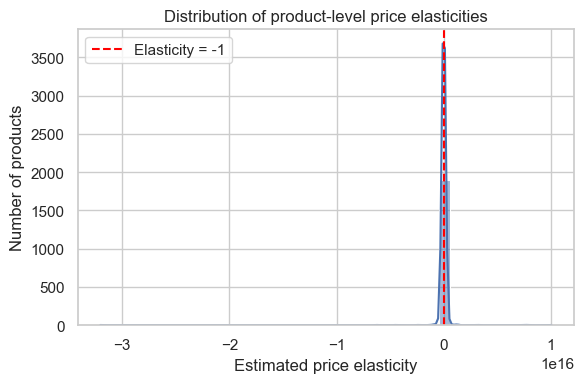

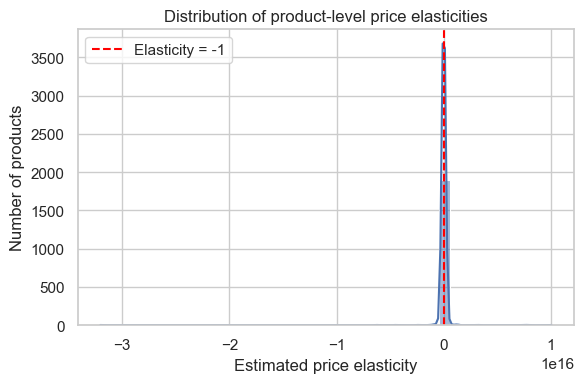

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# use cleaned table: no inf, enough changes, negative elasticities only
pe = prod_elasticity_clean.copy()

plt.figure(figsize=(6, 4))
sns.histplot(pe["elasticity"], bins=40, kde=True)
plt.axvline(-1, color="red", linestyle="--", label="Elasticity = -1")
plt.xlabel("Estimated price elasticity")
plt.ylabel("Number of products")
plt.title("Distribution of product-level price elasticities")
plt.legend()
plt.tight_layout()
plt.show()
import seaborn as sns
import matplotlib.pyplot as plt

# use cleaned table: no inf, enough changes, negative elasticities only
pe = prod_elasticity_clean.copy()

plt.figure(figsize=(6, 4))
sns.histplot(pe["elasticity"], bins=40, kde=True)
plt.axvline(-1, color="red", linestyle="--", label="Elasticity = -1")
plt.xlabel("Estimated price elasticity")
plt.ylabel("Number of products")
plt.title("Distribution of product-level price elasticities")
plt.legend()
plt.tight_layout()
plt.show()


# Which customers destroy margin at scale?

# Load data

In [36]:
import pandas as pd
from pathlib import Path

# fact_sales
fact_path = Path("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/fact_sales.csv")
fact_sales = pd.read_csv(fact_path)

# dim_customer (for country later)
cust_path = Path("/Users/reynoldtakurachoruma/Desktop/Online Retail (Pricing and Demand)/dim_customer.csv")
dim_customer = pd.read_csv(cust_path)

# working copy for customer margin analysis
df = fact_sales.copy()
df = df.merge(dim_customer[['CustomerID', 'Country']], on='CustomerID', how='left')

In [38]:
# pick an existing sales dataframe to work from (prefer customer-identified sales)
# (numpy is already imported earlier in the notebook)
if "df_sales_cust" in globals():
    df_cust = df_sales_cust.copy()
elif "df_sales" in globals():
    df_cust = df_sales.copy()
elif "fact_sales" in globals():
    df_cust = fact_sales.copy()
else:
    raise NameError("No suitable sales dataframe found: df_sales_cust, df_sales, or fact_sales must exist")

# from df_cust
median_price = (
    df_cust.groupby("StockCode")["Price"]
           .transform("median")
           .replace(0, np.nan)
)

df_cust["discount_pct"] = (
    (1 - df_cust["Price"] / median_price)
    .fillna(0)
    .clip(lower=0)
)

df_cust["is_discounted"] = df_cust["discount_pct"] > 0.05

cust_disc = (
    df_cust.groupby("CustomerID")
    .agg(
        total_revenue=("Revenue", "sum"),
        disc_revenue=("Revenue", lambda x: x[df_cust.loc[x.index, "is_discounted"]].sum()),
        num_invoices=("Invoice", "nunique")
    )
    .reset_index()
)

cust_disc["disc_share"] = cust_disc["disc_revenue"] / cust_disc["total_revenue"]
cust_disc = cust_disc.sort_values(by="disc_share", ascending=False)

# Simple margin model

In [50]:
df_cust = df[df["CustomerID"].notna()].copy()

# simple cost and profit model
cost_rate = 0.6  # you can tweak this
df_cust["cost"] = df_cust["Revenue"] * cost_rate
df_cust["profit"] = df_cust["Revenue"] - df_cust["cost"]


# Aggregate to customer level


In [51]:
customer_profit = (
    df_cust.groupby("CustomerID")
    .agg(
        total_revenue=("Revenue", "sum"),
        total_profit=("profit", "sum"),
        total_cost=("cost", "sum"),
        num_invoices=("Invoice", "nunique"),
        num_lines=("Invoice", "count"),
        total_qty=("Quantity", "sum")
    )
    .reset_index()
)

customer_profit["profit_margin"] = customer_profit["total_profit"] / customer_profit["total_revenue"]


# Define the margin destroyers 

In [52]:
# thresholds you can tune
min_revenue = customer_profit["total_revenue"].quantile(0.75)  # top 25% by revenue
low_margin_cut = 0.1  # <10% margin treated as bad

high_value = customer_profit[customer_profit["total_revenue"] >= min_revenue]

margin_destroyers = high_value[
    (high_value["profit_margin"] <= low_margin_cut)
]

# sort: biggest revenue but poor margins first
margin_destroyers = margin_destroyers.sort_values("total_revenue", ascending=False)

margin_destroyers.head(20)


,CustomerID,total_revenue,total_profit,total_cost,num_invoices,num_lines,total_qty,profit_margin


# Confirm df_cust is not empty

In [53]:
df_cust = df[df["CustomerID"].notna()].copy()
print(df_cust.shape)
df_cust.head()


(400916, 11)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Revenue,IsCancelled,IsReturn
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,False,False
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,False,False
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,False,False
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,False,False
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,False,False


In [54]:
df = fact_sales.copy()
print(df["CustomerID"].isna().mean())  # should be < 1.0


0.20568224595328194


# Build customer_profit

In [55]:
cost_rate = 0.6

df_cust = df[df["CustomerID"].notna()].copy()
df_cust["cost"] = df_cust["Revenue"] * cost_rate
df_cust["profit"] = df_cust["Revenue"] - df_cust["cost"]

customer_profit = (
    df_cust.groupby("CustomerID")
    .agg(
        total_revenue=("Revenue", "sum"),
        total_profit=("profit", "sum"),
        total_cost=("cost", "sum"),
        num_invoices=("Invoice", "nunique"),
        num_lines=("Invoice", "count"),
        total_qty=("Quantity", "sum")
    )
    .reset_index()
)

customer_profit["profit_margin"] = customer_profit["total_profit"] / customer_profit["total_revenue"]

print(customer_profit.shape)
customer_profit.head()


(4312, 8)


,CustomerID,total_revenue,total_profit,total_cost,num_invoices,num_lines,total_qty,profit_margin
0,12346.0,372.86,149.144,223.716,11,33,70,0.4
1,12347.0,1323.32,529.328,793.992,2,71,828,0.4
2,12348.0,222.16,88.864,133.296,1,20,373,0.4
3,12349.0,2671.14,1068.456,1602.684,3,102,993,0.4
4,12351.0,300.93,120.372,180.558,1,21,261,0.4


# Find margin destroying customers 

In [56]:
min_revenue = customer_profit["total_revenue"].quantile(0.75)
low_margin_cut = 0.2  # start with 20% instead of 10%

high_value = customer_profit[customer_profit["total_revenue"] >= min_revenue]
margin_destroyers = high_value[high_value["profit_margin"] <= low_margin_cut]

margin_destroyers.head()
margin_destroyers.shape
margin_destroyers = margin_destroyers.sort_values("total_revenue", ascending=False)
margin_destroyers.head(20)

,CustomerID,total_revenue,total_profit,total_cost,num_invoices,num_lines,total_qty,profit_margin


In [57]:
print(cust_disc["disc_share"].describe())

# merge disc_share into margin_destroyers (only if needed) to avoid KeyError
if 'disc_share' not in margin_destroyers.columns:
    md = margin_destroyers.merge(
        cust_disc[['CustomerID', 'disc_share']],
        on='CustomerID',
        how='left'
    )
else:
    md = margin_destroyers.copy()

# only select columns that actually exist (safe when dataframe is empty)
cols = [c for c in ["CustomerID", "total_revenue", "disc_share"] if c in md.columns]
print(md[cols].head())

count    4312.000000
mean        0.147480
std         0.262357
min         0.000000
25%         0.000000
50%         0.001015
75%         0.166443
max         1.000000
Name: disc_share, dtype: float64
Empty DataFrame
Columns: [CustomerID, total_revenue, disc_share]
Index: []


# Flag discount reliant customers 

In [47]:
# define threshold, e.g. 50%
threshold = 0.5

cust_disc["relies_on_discounts"] = np.where(
    cust_disc["disc_share"] >= threshold,
    "High discount reliance",
    "Low/normal discount reliance"
)
cust_disc.head()

,CustomerID,total_revenue,disc_revenue,num_invoices,disc_share,relies_on_discounts
501,13084.0,244.80,244.80,1,1.0,High discount reliance
2498,15838.0,81039.84,81039.84,16,1.0,High discount reliance
2365,15642.0,211.56,211.56,1,1.0,High discount reliance
2124,15299.0,6969.06,6969.06,6,1.0,High discount reliance
1609,14609.0,1769.28,1769.28,6,1.0,High discount reliance


# Scatterplot with color by group

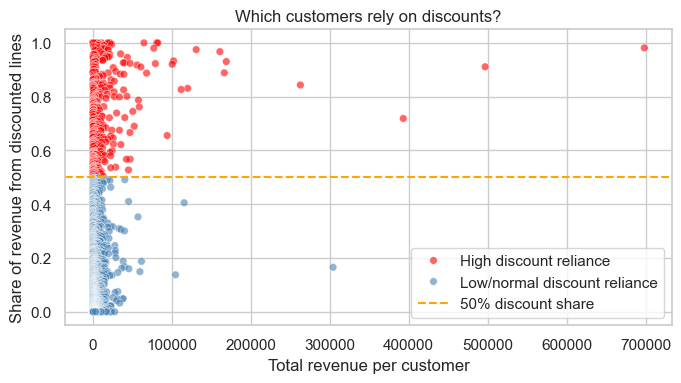

In [48]:
plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=cust_disc,
    x="total_revenue",
    y="disc_share",
    hue="relies_on_discounts",
    palette={"Low/normal discount reliance": "steelblue",
             "High discount reliance": "red"},
    alpha=0.6,
    s=30
)

plt.axhline(threshold, color="orange", linestyle="--", label=f"{int(threshold*100)}% discount share")
plt.xlabel("Total revenue per customer")
plt.ylabel("Share of revenue from discounted lines")
plt.title("Which customers rely on discounts?")
plt.legend()
plt.tight_layout()
plt.show()
